In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Read file
data = pd.read_csv("../consumption_temp.csv")
# Convert datatypes
data["time"] = pd.to_datetime(data["time"])
data["consumption"] = pd.to_numeric(data["consumption"])
data["temperature"] = pd.to_numeric(data["temperature"])


## Helsinki

In [3]:
# Filter away helsingfors with less than 4.5 in consumption as it seems like noise.
mask = (data["location"]!= "helsingfors") | ((data["location"] == "helsingfors"))
data = data[mask]

# Split into seperate dataframes for each city
data_cities = {location: data[data["location"] == location] for location in data["location"].unique()}


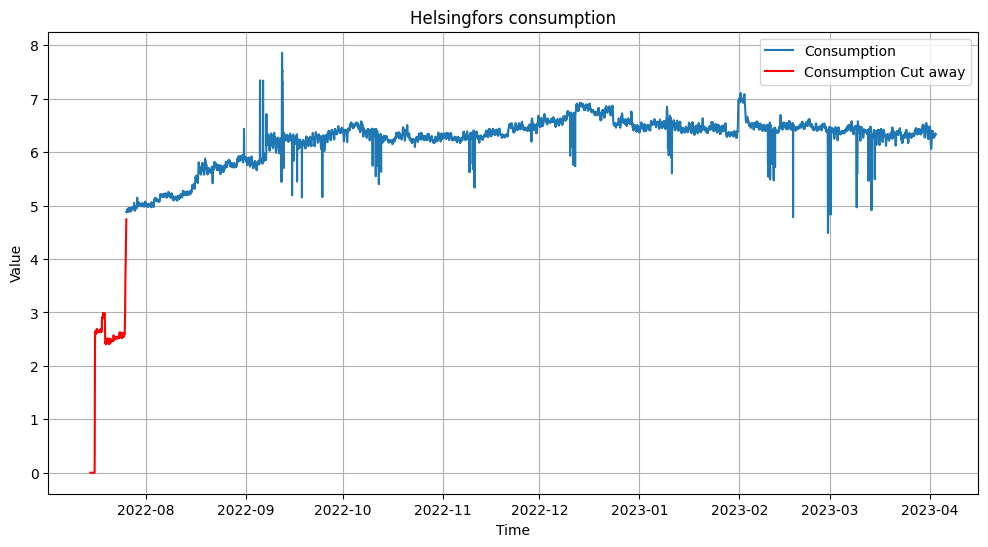

Timestamp('2022-07-14 21:00:00')

In [4]:
#plot helsingfors
plt.figure(figsize=(12, 6))  # Set the figure size (adjust as needed)
helsingfors_cut = data[(data['location']=='helsingfors') & (data["time"] <= "2022-07-26 00:00:00")]

helsingfors_keep = data[(data['location']=='helsingfors') & (data["time"] > "2022-07-26 00:00:00")]

plt.plot(helsingfors_keep['time'], helsingfors_keep['consumption'], label='Consumption', linestyle='-')
plt.plot(helsingfors_cut['time'], helsingfors_cut['consumption'], label='Consumption Cut away', linestyle='-', color="red")
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Helsingfors consumption')
plt.legend()
plt.grid(True)

plt.show()
data[data['location']=='helsingfors']['time'].min()

In [5]:
normalize_features = True

# Plot
# for city, city_data in data_cities.items():

#     # Normalize the "consumption" and "temperature" columns using Min-Max scaling
#     min_consumption = city_data['consumption'].min()
#     max_consumption = city_data['consumption'].max()
#     min_temperature = city_data['temperature'].min()
#     max_temperature = city_data['temperature'].max()

#     normalized_city_data = city_data.copy()
#     if normalize_features:
#         normalized_city_data['consumption'] = (city_data['consumption'] - min_consumption) / (max_consumption - min_consumption)
#         normalized_city_data['temperature'] = 1 - ((city_data['temperature'] - min_temperature) / (max_temperature - min_temperature))
    

#     # Print correlation matrix
#     print(f"Correlation: {normalized_city_data.drop(columns=['location', 'time']).corr()}")
#     # Plot
#     plt.figure(figsize=(12, 6))  # Set the figure size (adjust as needed)

#     plt.plot(normalized_city_data['time'], normalized_city_data['consumption'], label='Consumption', linestyle='-')
#     plt.plot(normalized_city_data['time'], normalized_city_data['temperature'], label='Temperature inverse', linestyle='-')

#     plt.xlabel('Time')
#     plt.ylabel('Value')
#     plt.title(city)
#     plt.legend()
#     plt.grid(True)

#     plt.show()

# Remove outliers

In [6]:
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose

# Function to find outliers
def find_outliers(ts, window=40, sigma=4):
    rolling_mean = ts.rolling(window=window).mean()
    rolling_std = ts.rolling(window=window).std()
    outliers = np.abs(ts - rolling_mean) > (sigma * rolling_std)
    return outliers

# Plotting
for location in ["helsingfors"]:  # Assuming you have a list of locations
    city_data = data[data["location"] == location].copy()
    city_data = city_data.set_index('time')

    # Seasonal decomposition
    decomposition = seasonal_decompose(city_data['consumption'], model='additive', period=30)
    residuals = decomposition.resid

    # Find outliers
    outliers = (residuals > 0.6) | (residuals < -0.5)

    # Creating the figure
    fig = go.Figure()

    # Add traces for consumption and residuals
    fig.add_trace(go.Scatter(x=city_data.index, y=city_data['consumption'], mode='lines', name='Consumption'))
    fig.add_trace(go.Scatter(x=residuals.index, y=residuals, mode='lines', name='Seasonally decomposed residuals', line=dict(dash='dash')))

    # Add scatter trace for outliers
    fig.add_trace(go.Scatter(x=city_data.loc[outliers.index[outliers]].index, y=city_data.loc[outliers.index[outliers], 'consumption'], mode='markers', marker_color='red', name='Outliers'))
    fig.add_trace(go.Scatter(x=residuals.loc[outliers.index[outliers]].index, y=residuals.loc[outliers.index[outliers]], mode='markers', marker_color='red', showlegend=False))

    # Update layout
    fig.update_layout(title=f'{location.capitalize()} Consumption and Residuals with Outliers', xaxis_title='Time', yaxis_title='Value', legend_title="Legend", template="plotly_white")

    # Show plot
    fig.show()


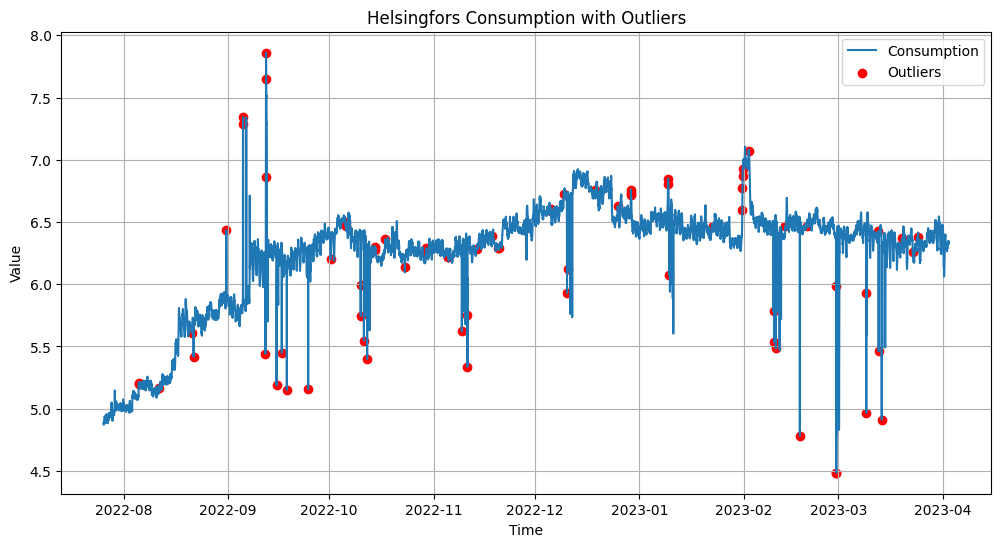

In [7]:


# Read file and preprocess
data = pd.read_csv("../consumption_temp.csv")
data["time"] = pd.to_datetime(data["time"])
data["consumption"] = pd.to_numeric(data["consumption"])
data["temperature"] = pd.to_numeric(data["temperature"])
mask = (data["location"] != "helsingfors") | ((data["location"] == "helsingfors")  & (data["time"] > "2022-07-26 00:00:00"))
data = data[mask]

# Function to find outliers
def find_outliers(ts, window=30, sigma=3):
    rolling_mean = ts.rolling(window=window).mean()
    rolling_std = ts.rolling(window=window).std()
    outliers = np.abs(ts - rolling_mean) > (sigma * rolling_std)
    return outliers

# Plotting
for location in ["helsingfors"]: #data["location"].unique():
    city_data = data[data["location"] == location]
    city_data = city_data.set_index('time')

    # Seasonal decomposition
    decomposition = seasonal_decompose(city_data['consumption'], model='additive', period=365)
    residuals = decomposition.resid.dropna()

    # Find outliers
    outliers = find_outliers(residuals)

    plt.figure(figsize=(12, 6))
    plt.plot(city_data['consumption'], label='Consumption', linestyle='-')
    plt.scatter(city_data.loc[outliers.index[outliers], 'consumption'].index, 
                city_data.loc[outliers.index[outliers], 'consumption'], 
                color='red', label='Outliers')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'{location.capitalize()} Consumption with Outliers')
    plt.legend()
    plt.grid(True)
    plt.show()

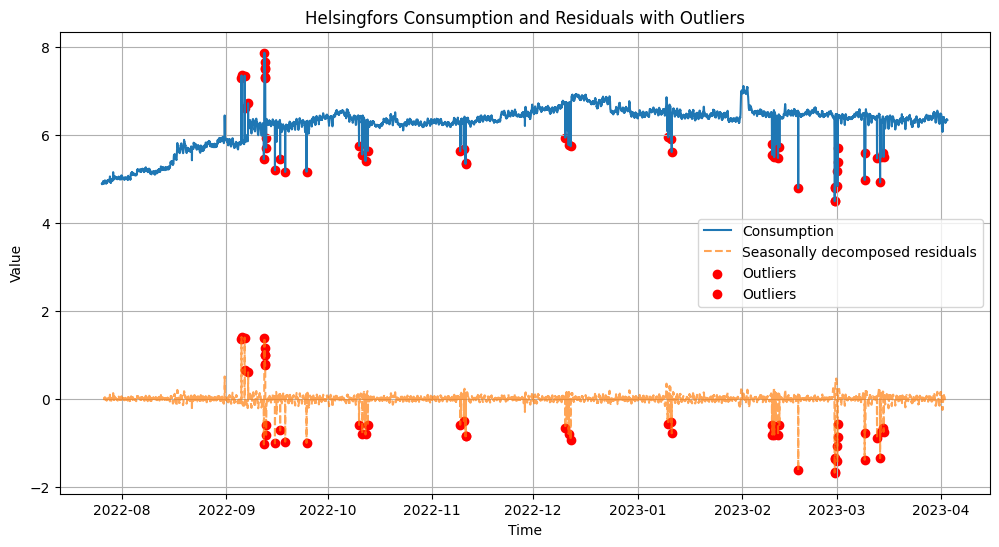

In [8]:
data_cleaned = data.copy().set_index("time")
# Function to find outliers
def find_outliers(ts, window=40, sigma=4):
    rolling_mean = ts.rolling(window=window).mean()
    rolling_std = ts.rolling(window=window).std()
    outliers = np.abs(ts - rolling_mean) > (sigma * rolling_std)
    return outliers

# Plotting
for location in ["helsingfors"]:  # data["location"].unique():
    city_data = data[data["location"] == location].copy()
    city_data = city_data.set_index('time')

    # Seasonal decomposition
    # decomposition = seasonal_decompose(city_data['consumption'], model='additive', period=365)
    decomposition = seasonal_decompose(city_data['consumption'], model='additive', period=30)
    
    # residuals = decomposition.resid.dropna()
    residuals = decomposition.resid

    # Find outliers
    # outliers = find_outliers(residuals)
    outliers = (residuals>0.6) | (residuals<-0.5)

    plt.figure(figsize=(12, 6))
    plt.plot(city_data['consumption'], label='Consumption', linestyle='-')
    plt.plot(residuals, label='Seasonally decomposed residuals', linestyle='--', alpha=0.7)
    plt.scatter(city_data.loc[outliers.index[outliers], 'consumption'].index, 
                city_data.loc[outliers.index[outliers], 'consumption'], 
                color='red', label='Outliers', marker='o')
    plt.scatter(residuals.loc[outliers.index[outliers]].index, 
                residuals.loc[outliers.index[outliers]], 
                color='red', label='Outliers', marker='o')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'{location.capitalize()} Consumption and Residuals with Outliers')
    plt.legend()
    plt.grid(True)
    plt.show()
    data_cleaned[data_cleaned["location"] == location].loc[outliers.index] = city_data.loc[outliers.index][~outliers]



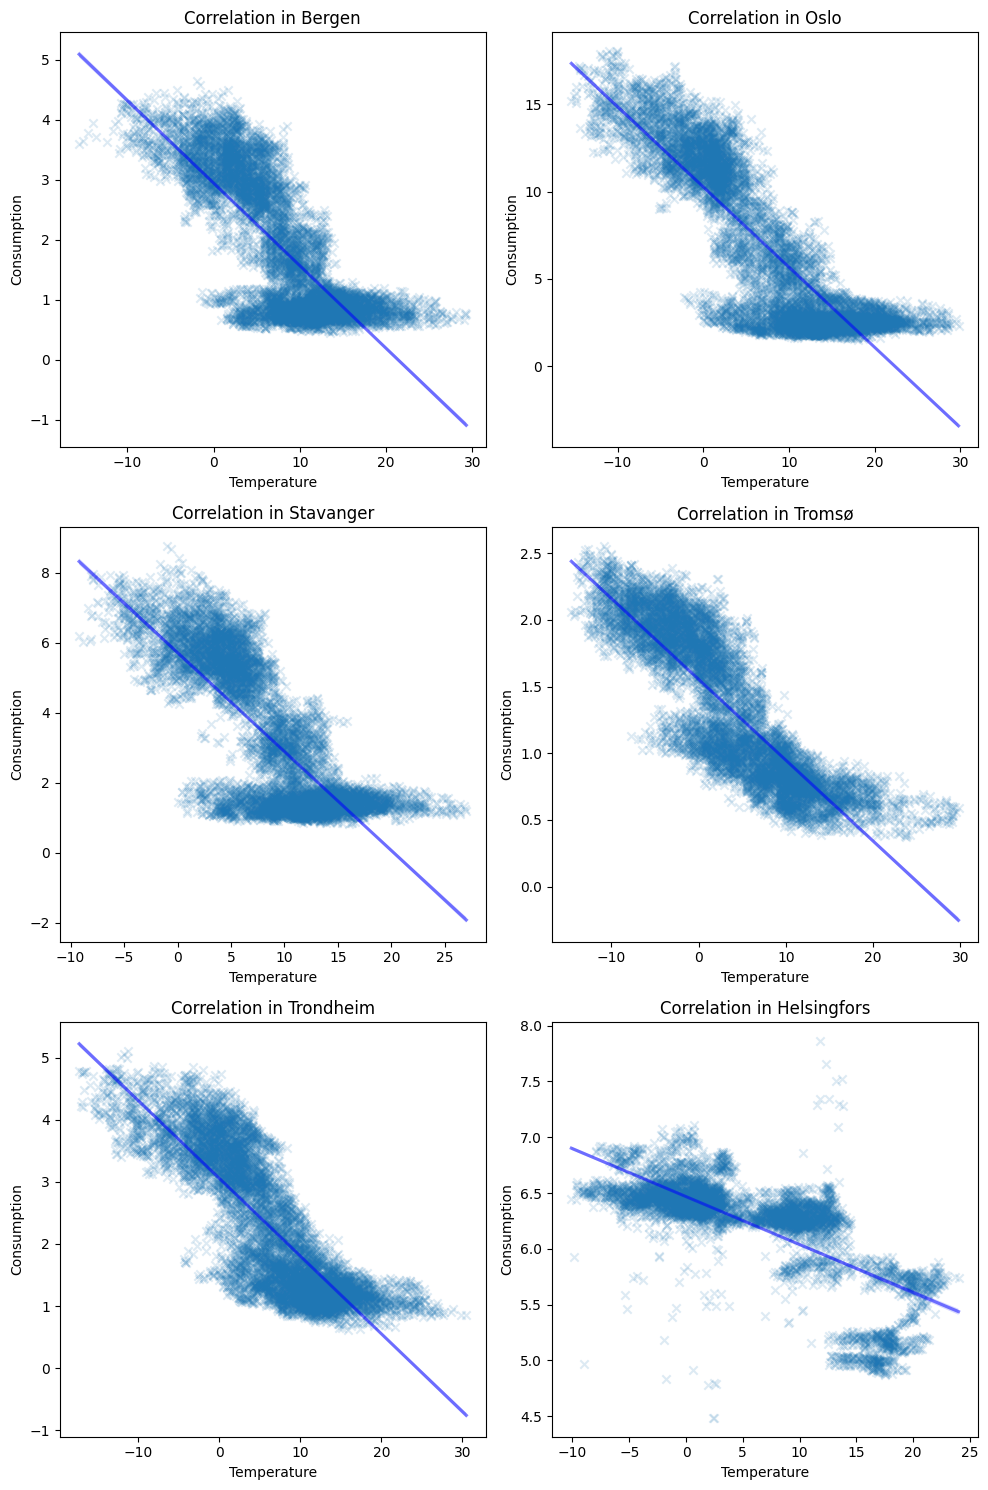

In [9]:
import statsmodels.api as sm

# Number of locations and grid layout
num_locations = len(data_cleaned["location"].unique())
grid_rows = 3
grid_cols = 2

# Create a figure with subplots
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(10, 15)) # Adjust size as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()
for i, location in enumerate(data_cleaned["location"].unique()):
    # Filter data for the current location
    loc_data = data_cleaned[data_cleaned["location"] == location]

    # Ensure data is sorted by time
    loc_data = loc_data.sort_values(by='time')


    # Plotting the correlation on the subplot
    ax = axes[i]
    sns.regplot(data=loc_data, x='temperature', y='consumption', ax=ax, scatter_kws = { "alpha": 0.15},
            line_kws = {"color": "blue", "alpha": 0.5}, marker="x")
    # sns.scatterplot(data=loc_data, x='temperature', y='adjusted_consumption', ax=ax)
    ax.set_title(f'Correlation in {location.capitalize()}')
    ax.set_xlabel('Temperature')
    ax.set_ylabel('Consumption')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

C:\Users\Bruker\AppData\Local\Temp\ipykernel_24808\2641134329.py:54: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



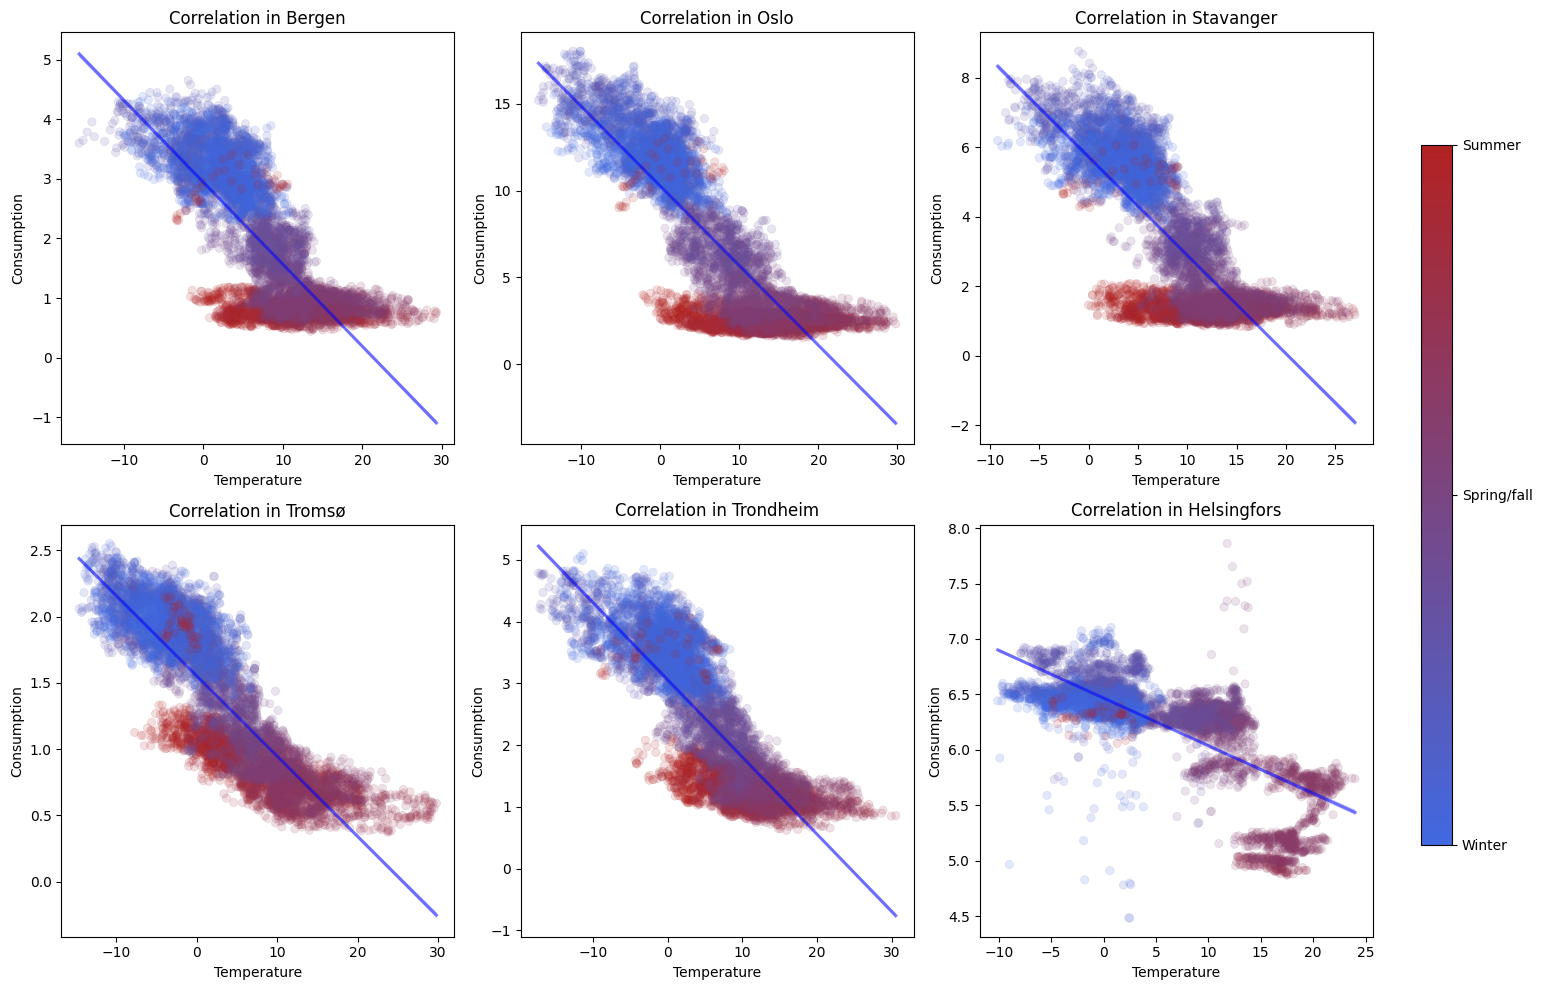

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Number of locations and grid layout
num_locations = len(data_cleaned["location"].unique())
grid_rows = 2
grid_cols = 3

# Create a colormap
cmap = mcolors.LinearSegmentedColormap.from_list("", ["royalblue", "firebrick"])  # Gradient from blue to red

# Normalize the color range
norm = plt.Normalize(-12, 0)  # Assuming the hue is set as -(loc_data.index.month+9)%12


# Create a figure with subplots
# fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(5*grid_cols, 5*grid_rows)) # Adjust size as needed
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(5*grid_cols + 0.5, 5*grid_rows)) # Add extra width for colorbar

# Flatten the axes array for easy iteration
axes = axes.flatten()
for i, location in enumerate(data_cleaned["location"].unique()):
    # Filter data for the current location
    loc_data = data_cleaned[data_cleaned["location"] == location]

    # Ensure data is sorted by time
    loc_data = loc_data.sort_values(by='time')

    # Plotting the correlation on the subplot
    ax = axes[i]
    sns.scatterplot(data=loc_data, x='temperature', y='consumption', ax=ax, hue=-(loc_data.index.month+9)%12, palette=cmap, legend=False, alpha=0.15, edgecolor=None)
    
    # Optional: Adding a regression line
    sns.regplot(data=loc_data, x='temperature', y='consumption', ax=ax, scatter=False, line_kws={"color": "blue", "alpha": 0.5})

    ax.set_title(f'Correlation in {location.capitalize()}')
    ax.set_xlabel('Temperature')
    ax.set_ylabel('Consumption')


# Create a scalar mappable for the colorbar
norm = plt.Normalize(-12, 0)  # Assuming the hue is set as -(loc_data.index.month+9)%12
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Create a new axes for the single colorbar on the right side of the plot
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) # x, y, width, height of the colorbar
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_ticks([-12, -6, 0])  # Only two ticks for Winter and Summer
cbar.set_ticklabels(['Winter', 'Spring/fall', 'Summer'])

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rectangle in which to fit the subplots
plt.show()

# # Adjust layout and show the plot
# plt.tight_layout()
# plt.show()


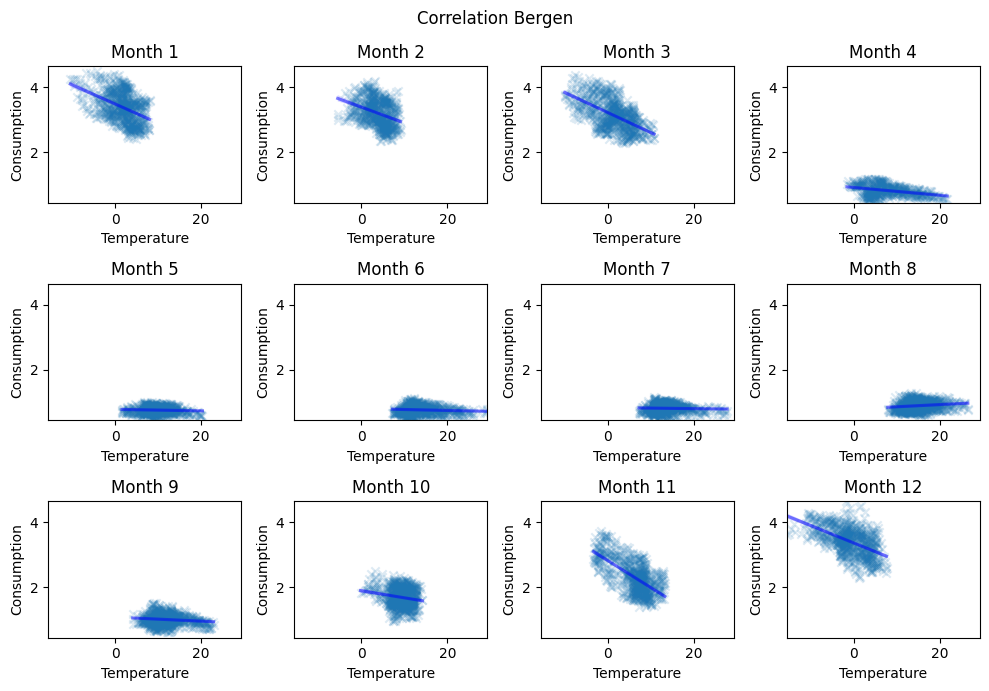

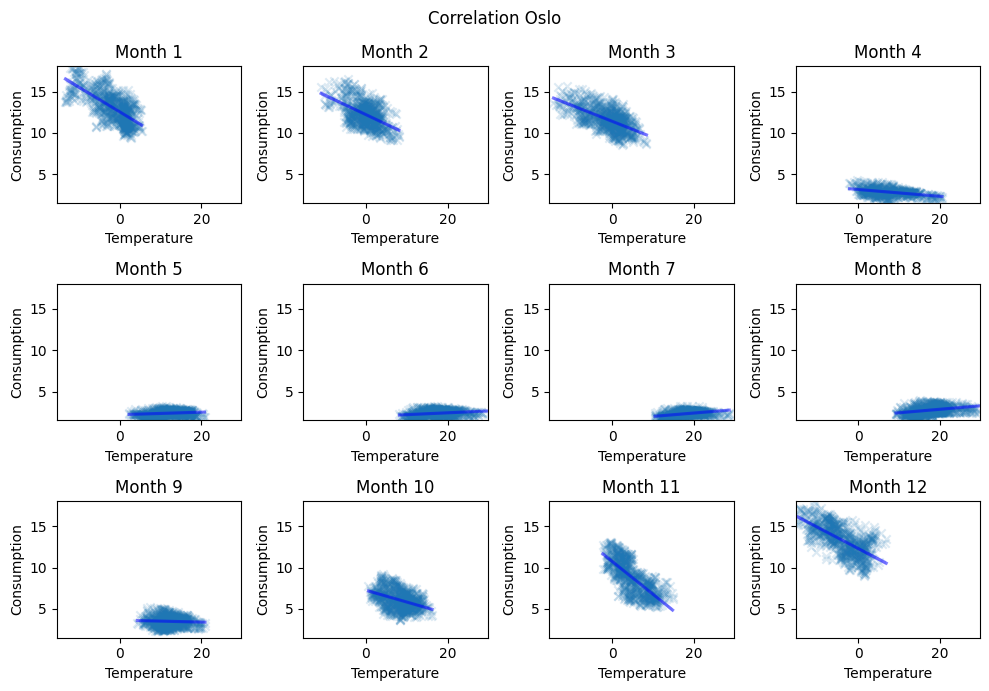

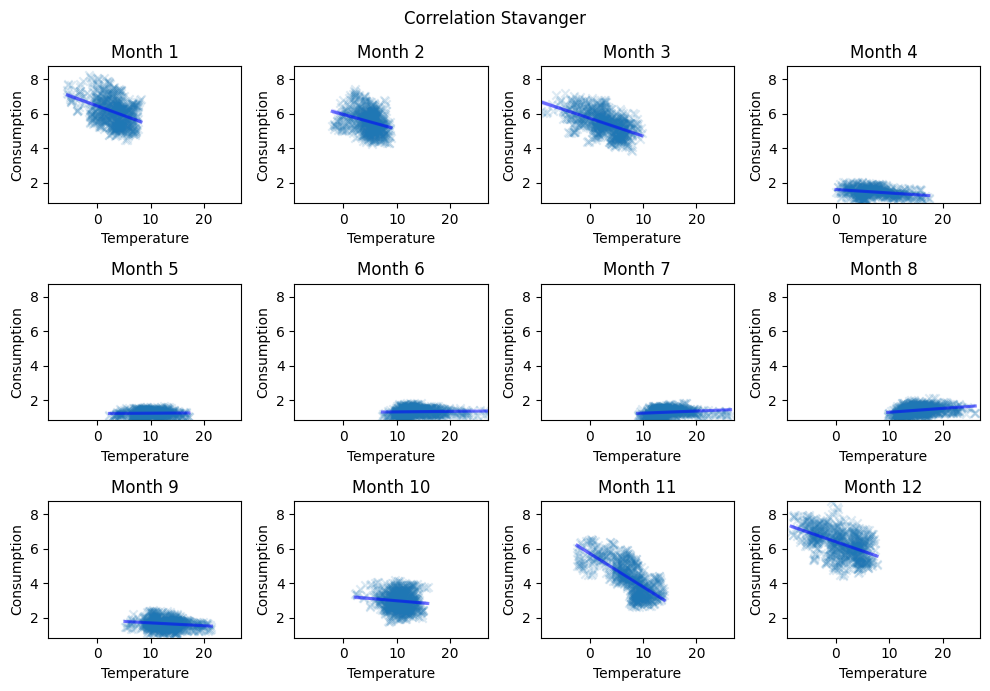

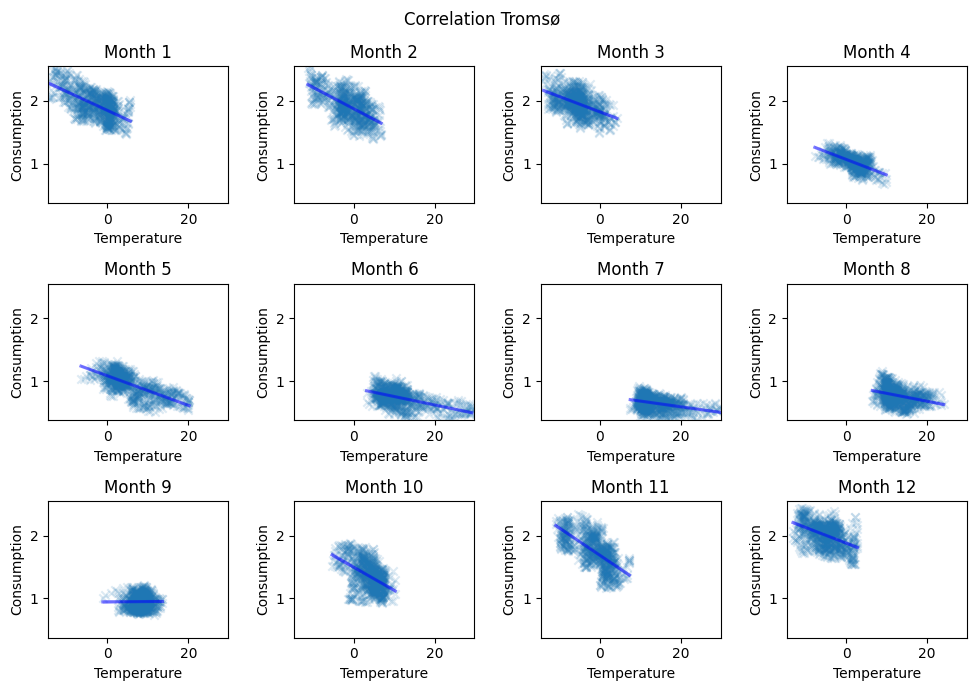

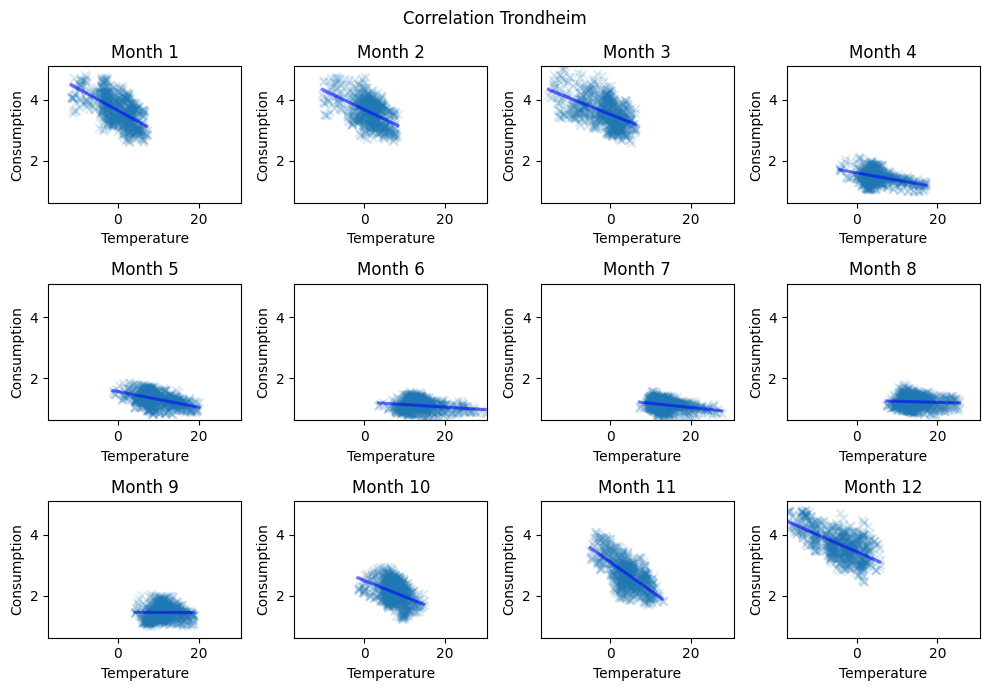

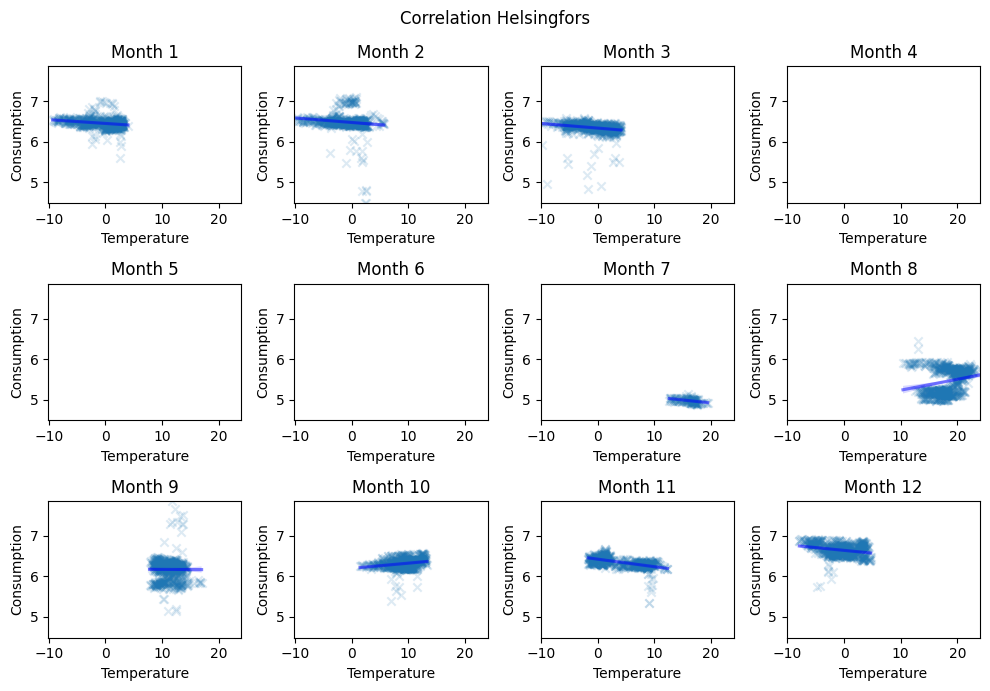

In [11]:
import statsmodels.api as sm

for location in data_cleaned["location"].unique():
    # Number of locations and grid layout
    num_locations = len(data_cleaned["location"].unique())
    grid_rows = 3
    grid_cols = 4

    # Create a figure with subplots
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(10, 7)) # Adjust size as needed
    fig.suptitle(f'Correlation {location.capitalize()}')
    # Flatten the axes array for easy iteration
    axes = axes.flatten()
    all_data = data_cleaned[data_cleaned["location"] == location].copy()
    all_data = all_data[all_data.index < '2023-04-01 00:00:00']
    # for i, location in enumerate(data_cleaned["location"].unique()):
    for month in range(12):
        # Filter data for the current location
        loc_data = all_data[all_data.index.month.isin([month+1])]

        # Ensure data is sorted by time
        loc_data = loc_data.sort_values(by='time')

        # Seasonal Decomposition
        # Assuming daily data; adjust 'period' as necessary for your data's frequency
        # decomposition = sm.tsa.seasonal_decompose(loc_data['consumption'], model='additive', period=30)
        
        # Get the seasonally adjusted data
        # loc_data['adjusted_consumption'] = loc_data['consumption'] - decomposition.seasonal
        loc_data['adjusted_consumption'] = loc_data['consumption']

        # Plotting the correlation on the subplot
        ax = axes[month]
        sns.regplot(data=loc_data, x='temperature', y='adjusted_consumption', ax=ax, scatter_kws = { "alpha": 0.15},
                line_kws = {"color": "blue", "alpha": 0.5}, marker="x")
        # sns.scatterplot(data=loc_data, x='temperature', y='adjusted_consumption', ax=ax)
        ax.set_title(f'Month {month+1}')
        ax.set_xlim([all_data["temperature"].min(), all_data["temperature"].max()])
        ax.set_ylim([all_data["consumption"].min(), all_data["consumption"].max()])
        ax.set_xlabel('Temperature')
        ax.set_ylabel('Consumption')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

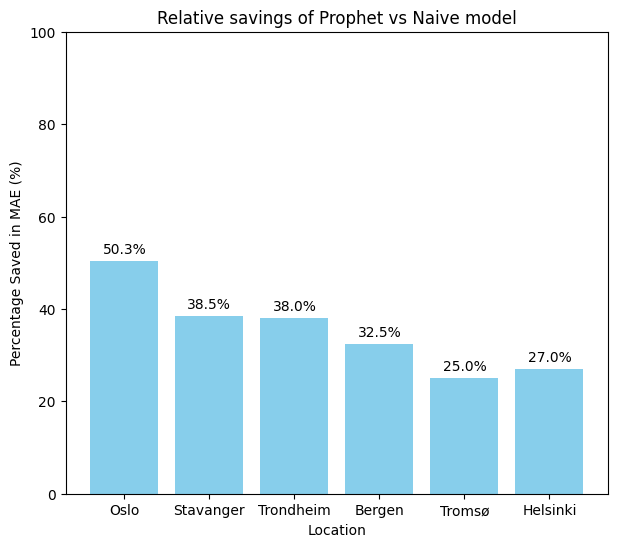

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Data from the LaTeX table, converted to positive values to represent percentage saved
data = {
    'Location': ['Oslo', 'Stavanger', 'Trondheim','Bergen', 'Tromsø', 'Helsinki'],
    'Percentage Saved in MAE': [ 50.3,  38.5, 38, 32.5, 25, 27]  # Positive values
}


# Convert to DataFrame
df = pd.DataFrame(data)

# Create a bar chart using Matplotlib
plt.figure(figsize=(7, 6))
plt.bar(df['Location'], df['Percentage Saved in MAE'], color='skyblue')
plt.ylim(0, 100)

# Add labels and title
plt.xlabel('Location')
plt.ylabel('Percentage Saved in MAE (%)')
plt.title('Relative savings of Prophet vs Naive model')

# Add value labels on top of each bar
for i, v in enumerate(df['Percentage Saved in MAE']):
    plt.text(i, v + 1, f"{v}%", ha='center', va='bottom')

plt.show()

# Seasonality decomposition

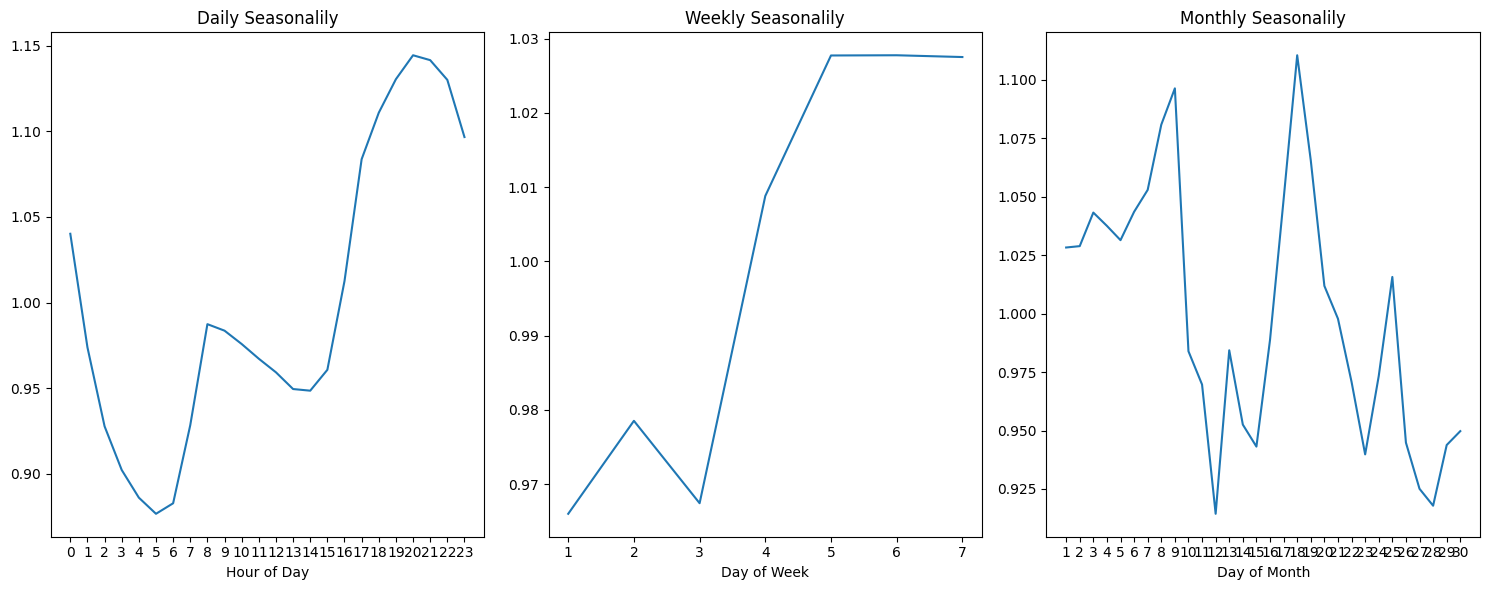

In [13]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming 'cleaned_data' is your DataFrame and it's indexed by time
# Filter data for "Bergen"
bergen_data = data_cleaned[(data_cleaned['location'] == 'bergen') & (data_cleaned.index>=pd.to_datetime('2023.01.01'))]['consumption']

# Decompose for different seasonal frequencies
# Daily (assuming data is in hours and a day has 24 hours)
daily_decompose = seasonal_decompose(bergen_data, model='multiplicative', period=24)

# Weekly (7 days * 24 hours)
weekly_decompose = seasonal_decompose(bergen_data, model='multiplicative', period=24*7)

# Monthly (approx. 30 days * 24 hours)
monthly_decompose = seasonal_decompose(bergen_data, model='multiplicative', period=24*30)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# Daily decomposition - Show last 24 hours
hours_of_day = list(range(24))
axes[0].plot(hours_of_day, daily_decompose.seasonal[-24:])
axes[0].set_title('Daily Seasonalily')
axes[0].set_xlabel('Hour of Day')
axes[0].set_xticks(hours_of_day)

# Weekly decomposition - Show last 7 days
days_of_week = list(range(1, 8))
axes[1].plot(days_of_week, weekly_decompose.seasonal.resample('D').mean()[-7:].resample('D').mean())
axes[1].set_title('Weekly Seasonalily')
axes[1].set_xlabel('Day of Week')
axes[1].set_xticks(days_of_week)

# Monthly decomposition - Show last 30 days
days_of_month = list(range(1, 31))
axes[2].plot(days_of_month, monthly_decompose.seasonal.resample('D').mean()[-30:].resample('D').mean())
axes[2].set_title('Monthly Seasonalily')
axes[2].set_xlabel('Day of Month')
axes[2].set_xticks(days_of_month)

plt.tight_layout()
plt.show()

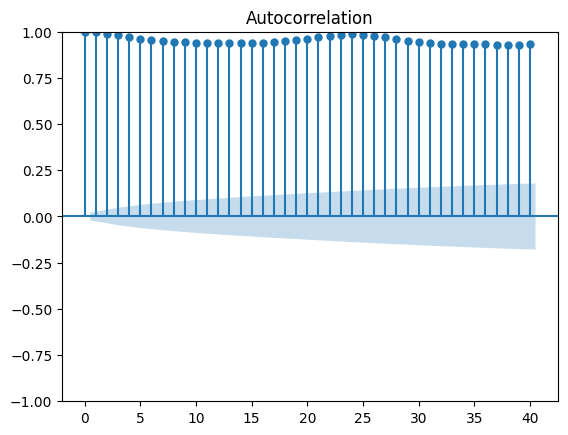

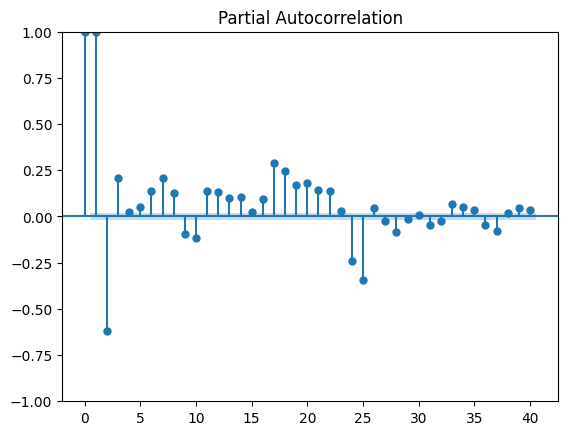

In [15]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
bergen_data = data_cleaned[(data_cleaned['location'] == 'bergen')]['consumption']

plot_acf(bergen_data)
plot_pacf(bergen_data)
plt.show()

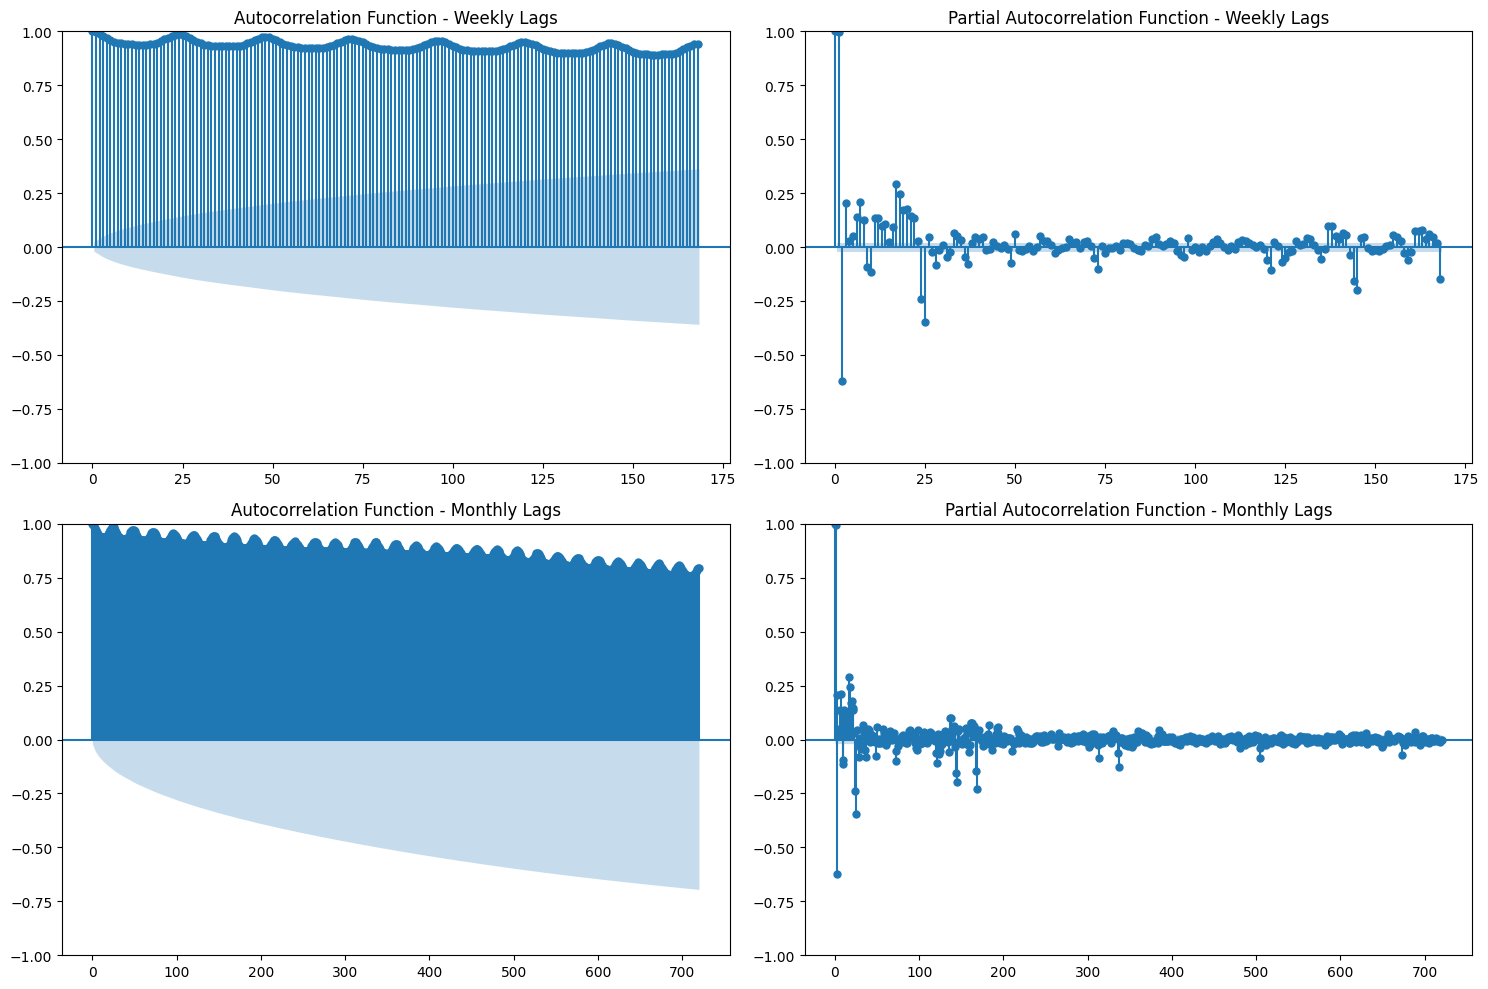

In [17]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming 'bergen_data' contains the consumption data for the location 'Bergen'
# Adjust the number of lags to explore weekly and monthly patterns
daily_lags = 24
weekly_lags = 168  # 7 days * 24 hours
monthly_lags = 720  # 30 days * 24 hours

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plotting ACF for weekly and monthly lags
plot_acf(bergen_data, ax=axes[0, 0], lags=weekly_lags)
axes[0, 0].set_title('Autocorrelation Function - Weekly Lags')

plot_acf(bergen_data, ax=axes[1, 0], lags=monthly_lags)
axes[1, 0].set_title('Autocorrelation Function - Monthly Lags')

# Plotting PACF for weekly and monthly lags
plot_pacf(bergen_data, ax=axes[0, 1], lags=weekly_lags)
axes[0, 1].set_title('Partial Autocorrelation Function - Weekly Lags')

plot_pacf(bergen_data, ax=axes[1, 1], lags=monthly_lags)
axes[1, 1].set_title('Partial Autocorrelation Function - Monthly Lags')

plt.tight_layout()
plt.show()